<a href="https://colab.research.google.com/github/yassiracharki/DeepLearningProjrects/blob/main/binary_text_classification_yelp_reviews_cnn_90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Binary Text Classification Yelp Reviews CNN**

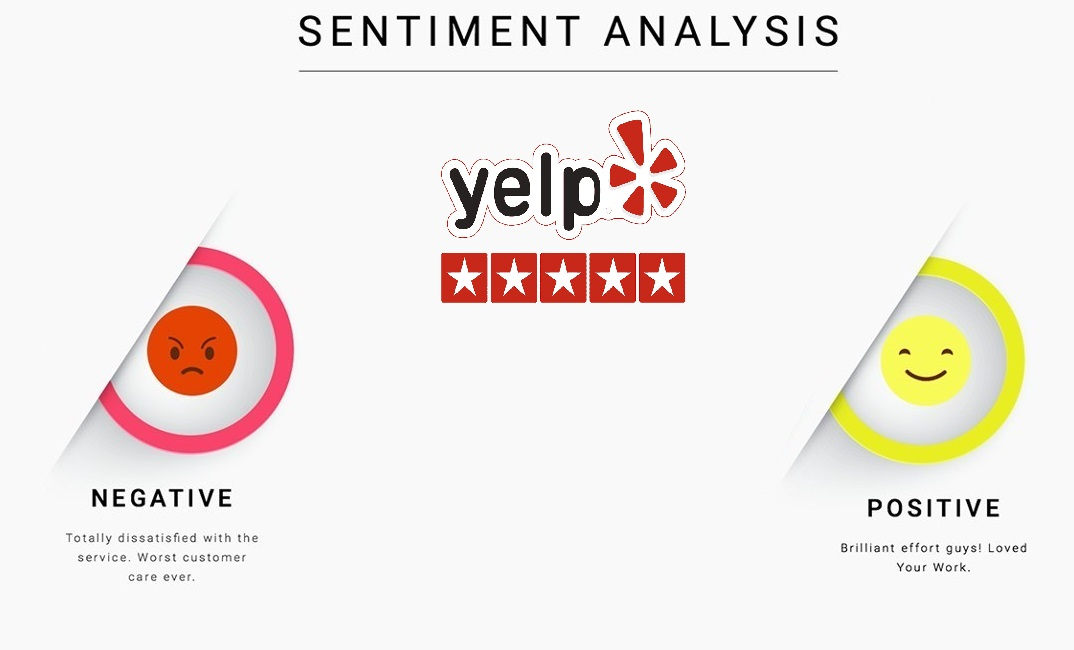

1. Download and Imports
2. Functions
3. Loading Dataset (Yelp Reviews)
4. Shuffeling and splitting the Data
5. Preprocessing and Tokenization
6. Dataset Visualization
7. Sequence Normalization and Encoding Labels
8. Model Preparation and Training
9. Visualizing and Evaluating the Results
10. Saving the model

on Github :  

on Google Colab : 

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Download and Imports

In [1]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

     |████████████████████████████████| 106 kB 5.8 MB/s 
     |████████████████████████████████| 287 kB 16.9 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
#Tensorflow and Keras and sklearn
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

#Charts
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Time
import time
import datetime

#Performance Plot
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata

%matplotlib inline

# fix random seed for reproducibility
seed = 3541
np.random.seed(seed)

# 2. Functions

In [3]:
# date_time function

def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()

In [4]:
# Performance Plot

def plot_performance(history=None, figure_directory=None, ylim_pad=[0, 0]):
    xlabel = 'Epoch'
    legends = ['Training', 'Validation']

    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']

    min_y = min(min(y1), min(y2))-ylim_pad[0]
    max_y = max(max(y1), max(y2))+ylim_pad[0]


    plt.subplot(121)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Accuracy\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    min_y = min(min(y1), min(y2))-ylim_pad[1]
    max_y = max(max(y1), max(y2))+ylim_pad[1]


    plt.subplot(122)

    plt.plot(y1)
    plt.plot(y2)

    plt.title('Model Loss\n'+date_time(1), fontsize=17)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.ylim(min_y, max_y)
    plt.legend(legends, loc='upper left')
    plt.grid()
    if figure_directory:
        plt.savefig(figure_directory+"/history")

    plt.show()

In [5]:
# Pre-Processing Function

def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

# 3. Loading Dataset (Yelp Reviews)

In [8]:
#Reading DAtaset from csv files to Pandas dataframes

dataset_train = pd.read_csv('/content/drive/MyDrive/Datasets/yelp_review_sa_binary_csv/train.csv')
dataset_test = pd.read_csv('/content/drive/MyDrive/Datasets/yelp_review_sa_binary_csv/test.csv')
dataset_val =  pd.read_csv('/content/drive/MyDrive/Datasets/yelp_review_sa_binary_csv/test.csv')

# 4. Shuffeling and splitting the Data

In [9]:
# Shuffling Data

val = dataset_val.sample(frac=1)
train = dataset_train.sample(frac=1)
test = dataset_test.sample(frac=1)

# Taking only a small peice of the dataset to avoid long training time

test = dataset_test.iloc[:50000,:]
train = dataset_train.iloc[50000:,:]
val = dataset_train.iloc[:50000,:]
train = dataset_train.iloc[50000:,:]
train = dataset_train.iloc[:100000,:]

# Splitting data to train and validation sets manually, only including neccessary columns

X_train = train['review_text'].values
y_train = train['class_index'].values

X_val = val['review_text'].values
y_val = val['class_index'].values

X_test = test['review_text'].values
y_test = test['class_index'].values

# 5. Preprocessing and Tokenization

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

In [10]:
%%time
#Pre-processing the Data (the Reviews)

X_train = pre_process_corpus(X_train)
X_val = pre_process_corpus(X_val)
X_test = pre_process_corpus(X_test)

  4%|▎         | 3531/100000 [00:00<00:25, 3822.76it/s]/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████| 38000/38000 [00:09<00:00, 3826.92it/s]

CPU times: user 47.8 s, sys: 1.78 s, total: 49.6 s
Wall time: 48.8 s


After Pre-processing it's time for tokenazation,To perform this transformation, keras provides the ```Tokenizer```

In [11]:
# Tokenazing the Data (the Reviews)

t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on train documents
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0

In [12]:
# Transforming Reviews to Sequences

X_train = t.texts_to_sequences(X_train)
X_test = t.texts_to_sequences(X_test)
X_val = t.texts_to_sequences(X_val)

# 6. Dataset Visualization

In [13]:
# Calculating the Vocabulary Size and the number of Reviews

print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Reviews={}".format(t.document_count))

Vocabulary size=196380
Number of Reviews=100000


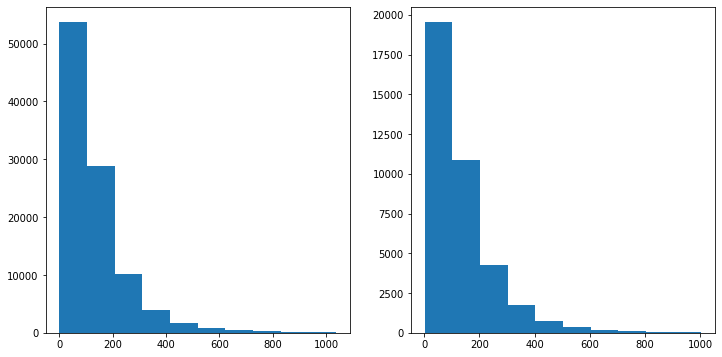

In [14]:
# Plotting the size of the sequences

import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in X_train]
test_lens = [len(s) for s in X_test]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

# 7. Sequence Normalization and Encoding Labels

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [15]:
# Padding the dataset to a maximum review length in words

MAX_SEQUENCE_LENGTH = 220

X_train = sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
X_val = sequence.pad_sequences(X_val, maxlen=MAX_SEQUENCE_LENGTH)

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [16]:
# Encoding Labels

le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

# 8. Model Preparation and Training

Before preparing the model, we need to set some variables that will be needed later

In [17]:
# Setting Vocabulary size and Emmbedding size

VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 300

# Setting learining rate within the Adam optimizer

Adam = tf.keras.optimizers.Adam(learning_rate=0.01)

# Setting the label smoothing within the loss function

loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)

# Setting an Early_stopping callback to monitor accuracy with a patience degree of 2

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

Since textual data is a sequence of words, we utilize ```1D``` convolutions to scan through the sentences.
The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

In [18]:
# Creating the model

model = Sequential()
# The Embedding layer
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
# The first one dimensional convolutional layer (32,4,same,relu)
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
# The first Max pooling layer (2)
model.add(MaxPooling1D(pool_size=2))
# The first Dropout layer (10%)
model.add(Dropout(rate=0.10))
# The second one dimensional convolutional layer (32,4,same,relu)
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
# The second Max pooling layer (2)
model.add(MaxPooling1D(pool_size=2))
# The second Dropout layer (10%)
model.add(Dropout(rate=0.10))
# The third one dimensional convolutional layer (32,4,same,relu)
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
# The third Max pooling layer (2)
model.add(MaxPooling1D(pool_size=2))
# The third Dropout layer (10%)
model.add(Dropout(rate=0.10))
# The Flattening layer
model.add(Flatten())
# The First Dense Layer (256,relu)
model.add(Dense(256, activation='relu'))
# The Second Dense Layer or Prediction layer (1,sigmoid)
model.add(Dense(1, activation='sigmoid'))
# Compiling the Model using the Binary_Crossontropy as a loss function and accuracy as a meseaure and Adam as an Optimizer
model.compile(loss=loss, optimizer=Adam, metrics=['accuracy'])
# Displaying the Model Schema
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 220, 300)          58914000  
                                                                 
 conv1d (Conv1D)             (None, 220, 32)           38432     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 110, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 110, 64)           8256      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 55, 64)           0         
 1D)                                                    

In [19]:
# Training the Model with GPU
with tf.device('/GPU:0'):
    history1 = model.fit(X_train, y_train, validation_data=(X_val,y_val),epochs=15, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/15
3125/3125 [==============================] - 209s 63ms/step - loss: 0.3834 - accuracy: 0.8939 - val_loss: 0.2967 - val_accuracy: 0.9529
Epoch 2/15
3125/3125 [==============================] - 196s 63ms/step - loss: 0.3238 - accuracy: 0.9358 - val_loss: 0.2683 - val_accuracy: 0.9720
Epoch 3/15
3125/3125 [==============================] - 197s 63ms/step - loss: 0.3052 - accuracy: 0.9491 - val_loss: 0.2522 - val_accuracy: 0.9781
Epoch 4/15
3125/3125 [==============================] - 196s 63ms/step - loss: 0.2773 - accuracy: 0.9616 - val_loss: 0.2448 - val_accuracy: 0.9804
Epoch 5/15
3125/3125 [==============================] - 196s 63ms/step - loss: 0.2686 - accuracy: 0.9666 - val_loss: 0.2411 - val_accuracy: 0.9839
Epoch 6/15
3125/3125 [==============================] - 193s 62ms/step - loss: 0.2657 - accuracy: 0.9703 - val_loss: 0.2369 - val_accuracy: 0.9867
Epoch 7/15
3125/3125 [==============================] - 196s 63ms/step - loss: 0.2671 - accuracy: 0.9719 - val_loss: 0

# 9. Visualizing and Evaluating the Results

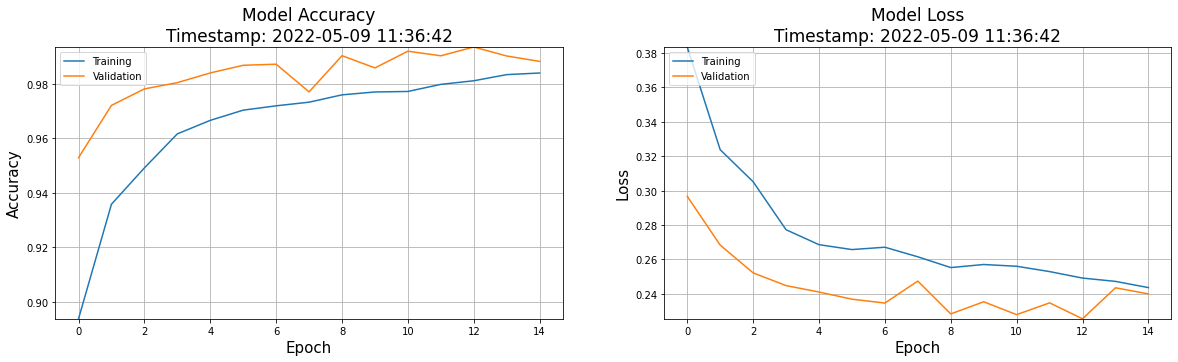

In [20]:
#Accuracy / Validation_Accuracy  and Loss / Validation_Loss Plot

plot_performance(history=history1)

In [21]:
# Final evaluation of the model

scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1188/1188 [==============================] - 7s 6ms/step - loss: 0.3653 - accuracy: 0.9068
Accuracy: 90.68%


# 10. Saving the model

In [23]:
model.save('Binary_Classification_CNN.h5')

If you have any questions, feel free to contact me at yassiracharki@gmail.com or on Kaggle (: